# 데이터 불러오기


In [ ]:
!pip install nltk

In [ ]:
import nltk
#corpus data 다운
nltk.download('book')

from nltk.book import *

In [3]:
# corpus id
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [ ]:
# austen-emma 불러오기
emma_raw = nltk.corpus.gutenberg.raw('austen-emma.txt').lower()
print(emma_raw)

# 데이터 전처리

In [5]:
#토큰화
from nltk.tokenize import word_tokenize

train_tokenized = word_tokenize(emma_raw)
print(len(train_tokenized ))
print(train_tokenized [:10])

191781
['[', 'emma', 'by', 'jane', 'austen', '1816', ']', 'volume', 'i', 'chapter']


In [6]:
#Stopword 제거
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

token_no_stopwords = [word for word in train_tokenized if word not in stop_words]
print(len(token_no_stopwords))

104360


In [7]:
#stemming(어간 추출)
from nltk.stem import PorterStemmer

pst = PorterStemmer()

stemmed_tokens = list(set([pst.stem(token) for token in token_no_stopwords]))
print(len(stemmed_tokens))
print(stemmed_tokens[0:10])

5259
['messag', 'spoon', 'georg', 'cross', 'new', 'replet', 'peep', 'embodi', 'danc', 'incap']


In [8]:
#i2w & w2i
i2w = stemmed_tokens
w2i = {word:i for i, word in enumerate(i2w)}

# Dataset & Dataloader

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

#CBOW
class CBOWDataset(Dataset):
    def __init__(self, tokens, w2i, window_size=2):
        self.tokens = tokens
        self.w2i = w2i

        self.x = []
        self.y = []

        token_ids = [self.w2i[pst.stem(token)] for token in tqdm(self.tokens) if pst.stem(token) in self.w2i]
        for i, id in enumerate(token_ids):
            if i-window_size >= 0 and i+window_size < len(token_ids):
                self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
                self.y.append(id)

        self.x = torch.LongTensor(self.x) 
        self.y = torch.LongTensor(self.y)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] 

In [10]:
#SkipGram
class SkipGramDataset(Dataset):
  def __init__(self, tokens, w2i, window_size=2):
    self.tokens = tokens
    self.w2i = w2i
    
    self.x = []
    self.y = []

    token_ids = [self.w2i[pst.stem(token)] for token in tqdm(self.tokens) if pst.stem(token) in self.w2i]  
    for i, id in enumerate(token_ids):
        if i-window_size >= 0 and i+window_size < len(token_ids):
            self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])
            self.x += [id] * 2 * window_size

    self.x = torch.LongTensor(self.x)  # (전체 데이터 개수)
    self.y = torch.LongTensor(self.y)  # (전체 데이터 개수)

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [30]:
cbow_set = CBOWDataset(train_tokenized,w2i)
skipgram_set = SkipGramDataset(train_tokenized,w2i)
print(cbow_set[0:4], len(cbow_set))
print(skipgram_set[0:4], len(skipgram_set))

  0%|          | 0/191781 [00:00<?, ?it/s]

  0%|          | 0/191781 [00:00<?, ?it/s]

(tensor([[4402, 4515,  569, 3169],
        [4515, 4309, 3169, 3944],
        [4309,  569, 3944, 3085],
        [ 569, 3169, 3085, 4222]]), tensor([4309,  569, 3169, 3944])) 109690
(tensor([4309, 4309, 4309, 4309]), tensor([4402, 4515,  569, 3169])) 438760


# Model 구현


In [53]:
#hyperparameters
batch_size= 128
learning_rate = 1e-4
num_epochs = 200
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Dataloader
cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

In [54]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, dim)
        self.linear = nn.Linear(dim, vocab_size)
        self.initialize()

    def initialize(self):
        nn.init.uniform_(self.embedding.weight, -1.0, 1.0)
        nn.init.normal_(self.linear.weight, 0, 0.01)
        nn.init.constant_(self.linear.bias, 0.0)

    def forward(self, x):
        embeddings = self.embedding(x)
        embeddings = torch.sum(embeddings, dim=1)
        output = self.linear(embeddings)
        return output

class SkipGram(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, dim)
        self.linear = nn.Linear(dim, vocab_size)
        self.initialize()
    
    def initialize(self):
        nn.init.uniform_(self.embedding.weight, -1.0, 1.0)
        nn.init.normal_(self.linear.weight, 0, 0.01)
        nn.init.constant_(self.linear.bias, 0.0)

    def forward(self, x): # x: (B)
        embeddings = self.embedding(x)  # (B, d_w)
        output = self.linear(embeddings)  # (B, V)
        return output

In [55]:
#model
cbow = CBOW(vocab_size=len(w2i), dim=100).to(device)
skipgram = SkipGram(vocab_size=len(w2i), dim=100).to(device)

In [56]:
#loss & optim
optimizer = optim.Adam(cbow.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#train
cbow.train()
for epoch in tqdm(range(1, num_epochs+1),leave=False):
    print("#" * 50)
    print(f"Epoch: {epoch}")
    for batch in tqdm(cbow_loader,leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        output = cbow(x)

        optimizer.zero_grad()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    print(f"Train loss: {loss.item()}")

print("Finished.")

  0%|          | 0/200 [00:00<?, ?it/s]

##################################################
Epoch: 1


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 7.558101177215576
##################################################
Epoch: 2


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 7.052188396453857
##################################################
Epoch: 3


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 6.77227783203125
##################################################
Epoch: 4


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 6.564782619476318
##################################################
Epoch: 5


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 6.40175724029541
##################################################
Epoch: 6


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 6.27092170715332
##################################################
Epoch: 7


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 6.16340446472168
##################################################
Epoch: 8


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 6.07228946685791
##################################################
Epoch: 9


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.992748737335205
##################################################
Epoch: 10


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.921652793884277
##################################################
Epoch: 11


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.856989860534668
##################################################
Epoch: 12


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.797405242919922
##################################################
Epoch: 13


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.741950035095215
##################################################
Epoch: 14


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.68992280960083
##################################################
Epoch: 15


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.640791893005371
##################################################
Epoch: 16


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.594132900238037
##################################################
Epoch: 17


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.549597263336182
##################################################
Epoch: 18


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.506889820098877
##################################################
Epoch: 19


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.465777397155762
##################################################
Epoch: 20


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.426069259643555
##################################################
Epoch: 21


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.387603759765625
##################################################
Epoch: 22


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.350240707397461
##################################################
Epoch: 23


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.313858985900879
##################################################
Epoch: 24


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.278360366821289
##################################################
Epoch: 25


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.2436604499816895
##################################################
Epoch: 26


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.20969295501709
##################################################
Epoch: 27


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.176395893096924
##################################################
Epoch: 28


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.143714904785156
##################################################
Epoch: 29


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.111602783203125
##################################################
Epoch: 30


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.080018043518066
##################################################
Epoch: 31


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.048925399780273
##################################################
Epoch: 32


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 5.018294811248779
##################################################
Epoch: 33


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.988104820251465
##################################################
Epoch: 34


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.958336353302002
##################################################
Epoch: 35


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.928976535797119
##################################################
Epoch: 36


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.900016784667969
##################################################
Epoch: 37


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.871448040008545
##################################################
Epoch: 38


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.843271732330322
##################################################
Epoch: 39


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.815485000610352
##################################################
Epoch: 40


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.788091659545898
##################################################
Epoch: 41


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.761090278625488
##################################################
Epoch: 42


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.734485626220703
##################################################
Epoch: 43


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.70827579498291
##################################################
Epoch: 44


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.68246603012085
##################################################
Epoch: 45


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.657058238983154
##################################################
Epoch: 46


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.63205623626709
##################################################
Epoch: 47


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.6074652671813965
##################################################
Epoch: 48


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.583293914794922
##################################################
Epoch: 49


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.559546947479248
##################################################
Epoch: 50


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.536230564117432
##################################################
Epoch: 51


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.513343334197998
##################################################
Epoch: 52


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.490882396697998
##################################################
Epoch: 53


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.46884298324585
##################################################
Epoch: 54


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.4472150802612305
##################################################
Epoch: 55


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.425987720489502
##################################################
Epoch: 56


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.405148983001709
##################################################
Epoch: 57


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.384686470031738
##################################################
Epoch: 58


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.364588737487793
##################################################
Epoch: 59


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.344844341278076
##################################################
Epoch: 60


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.325443744659424
##################################################
Epoch: 61


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.30637788772583
##################################################
Epoch: 62


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.2876362800598145
##################################################
Epoch: 63


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.269209384918213
##################################################
Epoch: 64


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.251087188720703
##################################################
Epoch: 65


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.233259201049805
##################################################
Epoch: 66


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.215719223022461
##################################################
Epoch: 67


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.19845724105835
##################################################
Epoch: 68


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.181463241577148
##################################################
Epoch: 69


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.164732933044434
##################################################
Epoch: 70


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.148255825042725
##################################################
Epoch: 71


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.132025241851807
##################################################
Epoch: 72


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.116032123565674
##################################################
Epoch: 73


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.100269317626953
##################################################
Epoch: 74


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.084730625152588
##################################################
Epoch: 75


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.069406509399414
##################################################
Epoch: 76


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.054289817810059
##################################################
Epoch: 77


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.039371967315674
##################################################
Epoch: 78


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.024646759033203
##################################################
Epoch: 79


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 4.010105133056641
##################################################
Epoch: 80


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.995741844177246
##################################################
Epoch: 81


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.98154878616333
##################################################
Epoch: 82


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.967519521713257
##################################################
Epoch: 83


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.9536471366882324
##################################################
Epoch: 84


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.939925193786621
##################################################
Epoch: 85


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.926347494125366
##################################################
Epoch: 86


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.9129114151000977
##################################################
Epoch: 87


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.899604082107544
##################################################
Epoch: 88


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.8864312171936035
##################################################
Epoch: 89


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.8733770847320557
##################################################
Epoch: 90


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.860445261001587
##################################################
Epoch: 91


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.847623348236084
##################################################
Epoch: 92


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.83491587638855
##################################################
Epoch: 93


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.822310447692871
##################################################
Epoch: 94


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.809812307357788
##################################################
Epoch: 95


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.7974092960357666
##################################################
Epoch: 96


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.7851064205169678
##################################################
Epoch: 97


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.772892475128174
##################################################
Epoch: 98


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.760772943496704
##################################################
Epoch: 99


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.748736619949341
##################################################
Epoch: 100


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.736788749694824
##################################################
Epoch: 101


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.7249176502227783
##################################################
Epoch: 102


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.7131314277648926
##################################################
Epoch: 103


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.701417922973633
##################################################
Epoch: 104


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.6897854804992676
##################################################
Epoch: 105


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.678223133087158
##################################################
Epoch: 106


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.666738986968994
##################################################
Epoch: 107


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.655320882797241
##################################################
Epoch: 108


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.643977165222168
##################################################
Epoch: 109


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.6326968669891357
##################################################
Epoch: 110


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.621490716934204
##################################################
Epoch: 111


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.6103451251983643
##################################################
Epoch: 112


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.5992698669433594
##################################################
Epoch: 113


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.588253974914551
##################################################
Epoch: 114


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.577305793762207
##################################################
Epoch: 115


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.5664172172546387
##################################################
Epoch: 116


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.5555942058563232
##################################################
Epoch: 117


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.5448291301727295
##################################################
Epoch: 118


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.5341291427612305
##################################################
Epoch: 119


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.523484945297241
##################################################
Epoch: 120


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.512906074523926
##################################################
Epoch: 121


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.5023813247680664
##################################################
Epoch: 122


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.4919211864471436
##################################################
Epoch: 123


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.4815142154693604
##################################################
Epoch: 124


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.4711754322052
##################################################
Epoch: 125


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.4608805179595947
##################################################
Epoch: 126


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.4506590366363525
##################################################
Epoch: 127


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.440483808517456
##################################################
Epoch: 128


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.430375814437866
##################################################
Epoch: 129


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.420311450958252
##################################################
Epoch: 130


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.41031551361084
##################################################
Epoch: 131


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.4003608226776123
##################################################
Epoch: 132


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.390474557876587
##################################################
Epoch: 133


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.380628824234009
##################################################
Epoch: 134


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.370849609375
##################################################
Epoch: 135


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.3611109256744385
##################################################
Epoch: 136


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.3514392375946045
##################################################
Epoch: 137


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.3418021202087402
##################################################
Epoch: 138


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.332240343093872
##################################################
Epoch: 139


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.322706937789917
##################################################
Epoch: 140


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.313244104385376
##################################################
Epoch: 141


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.3038134574890137
##################################################
Epoch: 142


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2944517135620117
##################################################
Epoch: 143


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2851202487945557
##################################################
Epoch: 144


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.275857925415039
##################################################
Epoch: 145


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2666232585906982
##################################################
Epoch: 146


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.257457971572876
##################################################
Epoch: 147


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.248317241668701
##################################################
Epoch: 148


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2392444610595703
##################################################
Epoch: 149


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.230196475982666
##################################################
Epoch: 150


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2212135791778564
##################################################
Epoch: 151


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2122557163238525
##################################################
Epoch: 152


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.2033610343933105
##################################################
Epoch: 153


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.1944894790649414
##################################################
Epoch: 154


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.185681104660034
##################################################
Epoch: 155


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.1768946647644043
##################################################
Epoch: 156


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.168170928955078
##################################################
Epoch: 157


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.1594667434692383
##################################################
Epoch: 158


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.150824546813965
##################################################
Epoch: 159


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.142202615737915
##################################################
Epoch: 160


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.133641481399536
##################################################
Epoch: 161


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.1251003742218018
##################################################
Epoch: 162


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.1166183948516846
##################################################
Epoch: 163


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.108154773712158
##################################################
Epoch: 164


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.099752426147461
##################################################
Epoch: 165


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0913658142089844
##################################################
Epoch: 166


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.083038806915283
##################################################
Epoch: 167


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.07472825050354
##################################################
Epoch: 168


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.066477060317993
##################################################
Epoch: 169


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.058239459991455
##################################################
Epoch: 170


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0500597953796387
##################################################
Epoch: 171


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0418944358825684
##################################################
Epoch: 172


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0337846279144287
##################################################
Epoch: 173


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.025689125061035
##################################################
Epoch: 174


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0176494121551514
##################################################
Epoch: 175


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0096235275268555
##################################################
Epoch: 176


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 3.0016531944274902
##################################################
Epoch: 177


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9936976432800293
##################################################
Epoch: 178


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9857945442199707
##################################################
Epoch: 179


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9779062271118164
##################################################
Epoch: 180


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9700701236724854
##################################################
Epoch: 181


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.962247610092163
##################################################
Epoch: 182


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9544763565063477
##################################################
Epoch: 183


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.946716785430908
##################################################
Epoch: 184


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9390077590942383
##################################################
Epoch: 185


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9313108921051025
##################################################
Epoch: 186


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9236626625061035
##################################################
Epoch: 187


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9160268306732178
##################################################
Epoch: 188


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9084384441375732
##################################################
Epoch: 189


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.9008629322052
##################################################
Epoch: 190


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.893334150314331
##################################################
Epoch: 191


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8858165740966797
##################################################
Epoch: 192


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8783462047576904
##################################################
Epoch: 193


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8708860874176025
##################################################
Epoch: 194


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8634724617004395
##################################################
Epoch: 195


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.856069564819336
##################################################
Epoch: 196


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.848712682723999
##################################################
Epoch: 197


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8413660526275635
##################################################
Epoch: 198


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.83406400680542
##################################################
Epoch: 199


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8267712593078613
##################################################
Epoch: 200


  0%|          | 0/857 [00:00<?, ?it/s]

Train loss: 2.8195230960845947
Finished.


In [67]:
#loss & optim
optimizer = optim.Adam(skipgram.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

#train
skipgram.train()
for epoch in tqdm(range(1, num_epochs+1),leave=False):
    print("#" * 50)
    print(f"Epoch: {epoch}")
    for batch in tqdm(skipgram_loader,leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        output = skipgram(x)

        optimizer.zero_grad()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    
    print(f"Train loss: {loss.item()}")

print("Finished.")

  0%|          | 0/200 [00:00<?, ?it/s]

##################################################
Epoch: 1


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 7.273813247680664
##################################################
Epoch: 2


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.857396125793457
##################################################
Epoch: 3


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.650563716888428
##################################################
Epoch: 4


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.511981010437012
##################################################
Epoch: 5


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.4102044105529785
##################################################
Epoch: 6


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.338118553161621
##################################################
Epoch: 7


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.2870917320251465
##################################################
Epoch: 8


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.249516010284424
##################################################
Epoch: 9


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.217267990112305
##################################################
Epoch: 10


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.186328411102295
##################################################
Epoch: 11


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.156284809112549
##################################################
Epoch: 12


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.127725601196289
##################################################
Epoch: 13


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.101168155670166
##################################################
Epoch: 14


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.076871871948242
##################################################
Epoch: 15


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.054838180541992
##################################################
Epoch: 16


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.034841060638428
##################################################
Epoch: 17


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 6.016514301300049
##################################################
Epoch: 18


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.99946403503418
##################################################
Epoch: 19


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.983363151550293
##################################################
Epoch: 20


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.967972278594971
##################################################
Epoch: 21


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.953132629394531
##################################################
Epoch: 22


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.938730239868164
##################################################
Epoch: 23


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.924682140350342
##################################################
Epoch: 24


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.9109320640563965
##################################################
Epoch: 25


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.897450923919678
##################################################
Epoch: 26


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.88422155380249
##################################################
Epoch: 27


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.871227741241455
##################################################
Epoch: 28


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.858456134796143
##################################################
Epoch: 29


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.8458967208862305
##################################################
Epoch: 30


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.83354377746582
##################################################
Epoch: 31


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.821387767791748
##################################################
Epoch: 32


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.809425354003906
##################################################
Epoch: 33


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.797652721405029
##################################################
Epoch: 34


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.786067008972168
##################################################
Epoch: 35


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.774665832519531
##################################################
Epoch: 36


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.763448238372803
##################################################
Epoch: 37


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.752410888671875
##################################################
Epoch: 38


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.741553783416748
##################################################
Epoch: 39


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.730871200561523
##################################################
Epoch: 40


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.720362186431885
##################################################
Epoch: 41


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.710025310516357
##################################################
Epoch: 42


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.699858665466309
##################################################
Epoch: 43


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.68986177444458
##################################################
Epoch: 44


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.680032730102539
##################################################
Epoch: 45


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.6703715324401855
##################################################
Epoch: 46


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.660876750946045
##################################################
Epoch: 47


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.651547431945801
##################################################
Epoch: 48


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.6423845291137695
##################################################
Epoch: 49


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.6333842277526855
##################################################
Epoch: 50


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.624544620513916
##################################################
Epoch: 51


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.615868091583252
##################################################
Epoch: 52


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.60734748840332
##################################################
Epoch: 53


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.598980903625488
##################################################
Epoch: 54


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.590766429901123
##################################################
Epoch: 55


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.582702159881592
##################################################
Epoch: 56


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.574782371520996
##################################################
Epoch: 57


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.567005634307861
##################################################
Epoch: 58


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.559365272521973
##################################################
Epoch: 59


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.5518574714660645
##################################################
Epoch: 60


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.5444769859313965
##################################################
Epoch: 61


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.5372209548950195
##################################################
Epoch: 62


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.530084609985352
##################################################
Epoch: 63


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.5230607986450195
##################################################
Epoch: 64


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.516147136688232
##################################################
Epoch: 65


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.50933837890625
##################################################
Epoch: 66


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.502634048461914
##################################################
Epoch: 67


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.496028423309326
##################################################
Epoch: 68


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.489517688751221
##################################################
Epoch: 69


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.483098983764648
##################################################
Epoch: 70


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.4767680168151855
##################################################
Epoch: 71


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.470524787902832
##################################################
Epoch: 72


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.464362621307373
##################################################
Epoch: 73


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.458282470703125
##################################################
Epoch: 74


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.452279090881348
##################################################
Epoch: 75


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.446350574493408
##################################################
Epoch: 76


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.440496444702148
##################################################
Epoch: 77


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.434712886810303
##################################################
Epoch: 78


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.428997993469238
##################################################
Epoch: 79


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.423350811004639
##################################################
Epoch: 80


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.4177703857421875
##################################################
Epoch: 81


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.41225528717041
##################################################
Epoch: 82


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.406803607940674
##################################################
Epoch: 83


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.401413917541504
##################################################
Epoch: 84


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.396087646484375
##################################################
Epoch: 85


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3908185958862305
##################################################
Epoch: 86


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3856120109558105
##################################################
Epoch: 87


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.380465984344482
##################################################
Epoch: 88


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3753767013549805
##################################################
Epoch: 89


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3703436851501465
##################################################
Epoch: 90


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3653669357299805
##################################################
Epoch: 91


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.360448360443115
##################################################
Epoch: 92


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.355585098266602
##################################################
Epoch: 93


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.350776672363281
##################################################
Epoch: 94


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3460235595703125
##################################################
Epoch: 95


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3413262367248535
##################################################
Epoch: 96


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.33668327331543
##################################################
Epoch: 97


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.332095623016357
##################################################
Epoch: 98


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.3275628089904785
##################################################
Epoch: 99


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.323082447052002
##################################################
Epoch: 100


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.318656921386719
##################################################
Epoch: 101


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.314284324645996
##################################################
Epoch: 102


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.309961795806885
##################################################
Epoch: 103


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.305692195892334
##################################################
Epoch: 104


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.301472187042236
##################################################
Epoch: 105


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.297301292419434
##################################################
Epoch: 106


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.293179512023926
##################################################
Epoch: 107


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.2891058921813965
##################################################
Epoch: 108


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.28507661819458
##################################################
Epoch: 109


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.281089782714844
##################################################
Epoch: 110


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.277146339416504
##################################################
Epoch: 111


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.273243427276611
##################################################
Epoch: 112


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.269381046295166
##################################################
Epoch: 113


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.265556812286377
##################################################
Epoch: 114


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.2617716789245605
##################################################
Epoch: 115


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.258023262023926
##################################################
Epoch: 116


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.254310131072998
##################################################
Epoch: 117


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.2506327629089355
##################################################
Epoch: 118


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.246987342834473
##################################################
Epoch: 119


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.243376731872559
##################################################
Epoch: 120


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.239797115325928
##################################################
Epoch: 121


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.236249923706055
##################################################
Epoch: 122


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.232734203338623
##################################################
Epoch: 123


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.229245662689209
##################################################
Epoch: 124


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.225787162780762
##################################################
Epoch: 125


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.22235631942749
##################################################
Epoch: 126


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.218950271606445
##################################################
Epoch: 127


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.215569019317627
##################################################
Epoch: 128


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.21221399307251
##################################################
Epoch: 129


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.208880424499512
##################################################
Epoch: 130


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.205569744110107
##################################################
Epoch: 131


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.202282428741455
##################################################
Epoch: 132


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.199016094207764
##################################################
Epoch: 133


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.195773601531982
##################################################
Epoch: 134


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1925530433654785
##################################################
Epoch: 135


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1893534660339355
##################################################
Epoch: 136


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1861748695373535
##################################################
Epoch: 137


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.183018684387207
##################################################
Epoch: 138


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.17988395690918
##################################################
Epoch: 139


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.17677116394043
##################################################
Epoch: 140


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.173678874969482
##################################################
Epoch: 141


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.170608997344971
##################################################
Epoch: 142


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.167558670043945
##################################################
Epoch: 143


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1645283699035645
##################################################
Epoch: 144


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.161516189575195
##################################################
Epoch: 145


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.158525466918945
##################################################
Epoch: 146


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.155553817749023
##################################################
Epoch: 147


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.152600288391113
##################################################
Epoch: 148


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1496663093566895
##################################################
Epoch: 149


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1467509269714355
##################################################
Epoch: 150


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.143853187561035
##################################################
Epoch: 151


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.140974044799805
##################################################
Epoch: 152


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.138113021850586
##################################################
Epoch: 153


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.135270118713379
##################################################
Epoch: 154


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.1324462890625
##################################################
Epoch: 155


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.129639625549316
##################################################
Epoch: 156


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.126852035522461
##################################################
Epoch: 157


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.124082565307617
##################################################
Epoch: 158


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.121330261230469
##################################################
Epoch: 159


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.118597984313965
##################################################
Epoch: 160


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.115882396697998
##################################################
Epoch: 161


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.113185405731201
##################################################
Epoch: 162


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.110508441925049
##################################################
Epoch: 163


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.107848167419434
##################################################
Epoch: 164


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.105206489562988
##################################################
Epoch: 165


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.102583885192871
##################################################
Epoch: 166


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.099980354309082
##################################################
Epoch: 167


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.097394943237305
##################################################
Epoch: 168


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.094828128814697
##################################################
Epoch: 169


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.092279434204102
##################################################
Epoch: 170


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.089749813079834
##################################################
Epoch: 171


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.087238788604736
##################################################
Epoch: 172


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.084746837615967
##################################################
Epoch: 173


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.082272529602051
##################################################
Epoch: 174


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.079817771911621
##################################################
Epoch: 175


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.0773797035217285
##################################################
Epoch: 176


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.074960708618164
##################################################
Epoch: 177


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.072558879852295
##################################################
Epoch: 178


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.070176124572754
##################################################
Epoch: 179


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.067811965942383
##################################################
Epoch: 180


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.065465927124023
##################################################
Epoch: 181


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.063138484954834
##################################################
Epoch: 182


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.0608296394348145
##################################################
Epoch: 183


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.0585408210754395
##################################################
Epoch: 184


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.056269645690918
##################################################
Epoch: 185


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.054016590118408
##################################################
Epoch: 186


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.051783561706543
##################################################
Epoch: 187


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.0495686531066895
##################################################
Epoch: 188


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.047372817993164
##################################################
Epoch: 189


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.045195579528809
##################################################
Epoch: 190


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.043038368225098
##################################################
Epoch: 191


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.040895938873291
##################################################
Epoch: 192


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.038775444030762
##################################################
Epoch: 193


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.036671161651611
##################################################
Epoch: 194


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.034584999084473
##################################################
Epoch: 195


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.032517433166504
##################################################
Epoch: 196


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.030468463897705
##################################################
Epoch: 197


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.028436660766602
##################################################
Epoch: 198


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.026425361633301
##################################################
Epoch: 199


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.024431228637695
##################################################
Epoch: 200


  0%|          | 0/3428 [00:00<?, ?it/s]

Train loss: 5.02245569229126
Finished.


#시각화

In [64]:
from sklearn.manifold import TSNE # 시각화를 위한 t-SNE 사용
import matplotlib.pyplot as plt

def render_TSNE(vocab, word_emb):
    tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=10000, random_state=32) # t-SNE 시각화를 위한 initialization
                                                                                         # perplexity를 조절하여 군집의 크기 및 분산도를 조절하는 효과가 납니다.
    _tsne = tsne.fit_transform(word_emb[:150]) # t-SNE 시각화 적용
    x_coordinate = _tsne[:,0] # x 좌표
    y_coordinate = _tsne[:,1] # y 좌표

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(vocab[:150]):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # 각 scatter들에 대해 단어 labeling

    plt.show()

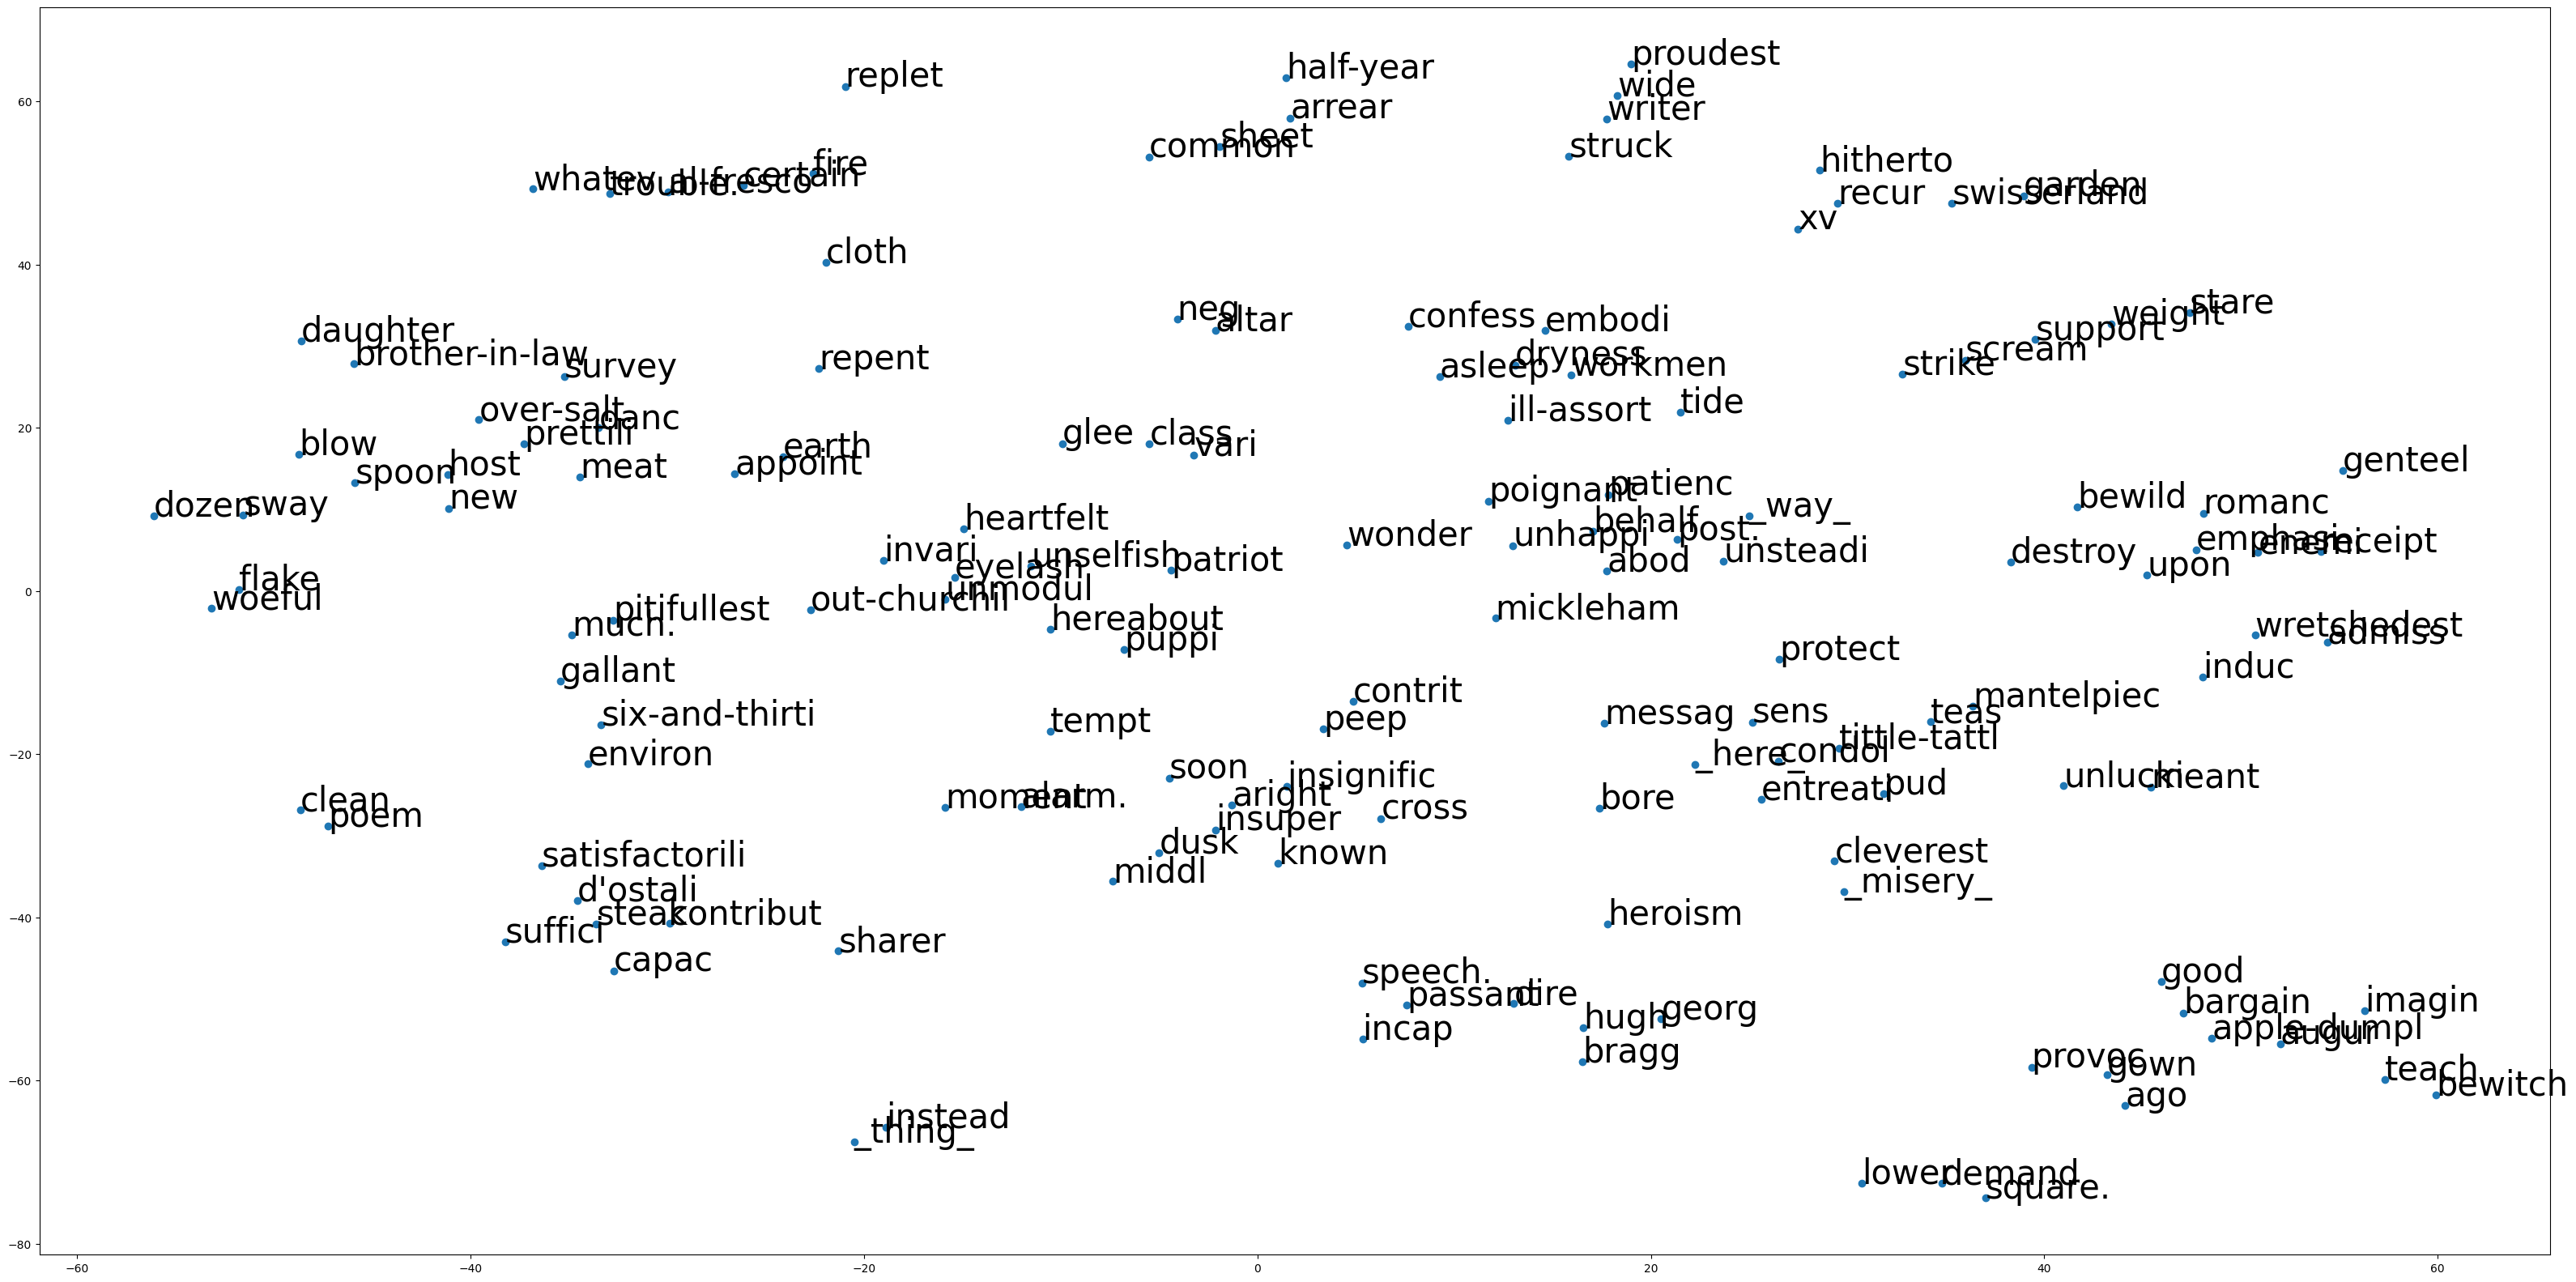

In [65]:
render_TSNE(i2w, cbow.embedding.weight.cpu().detach().numpy())

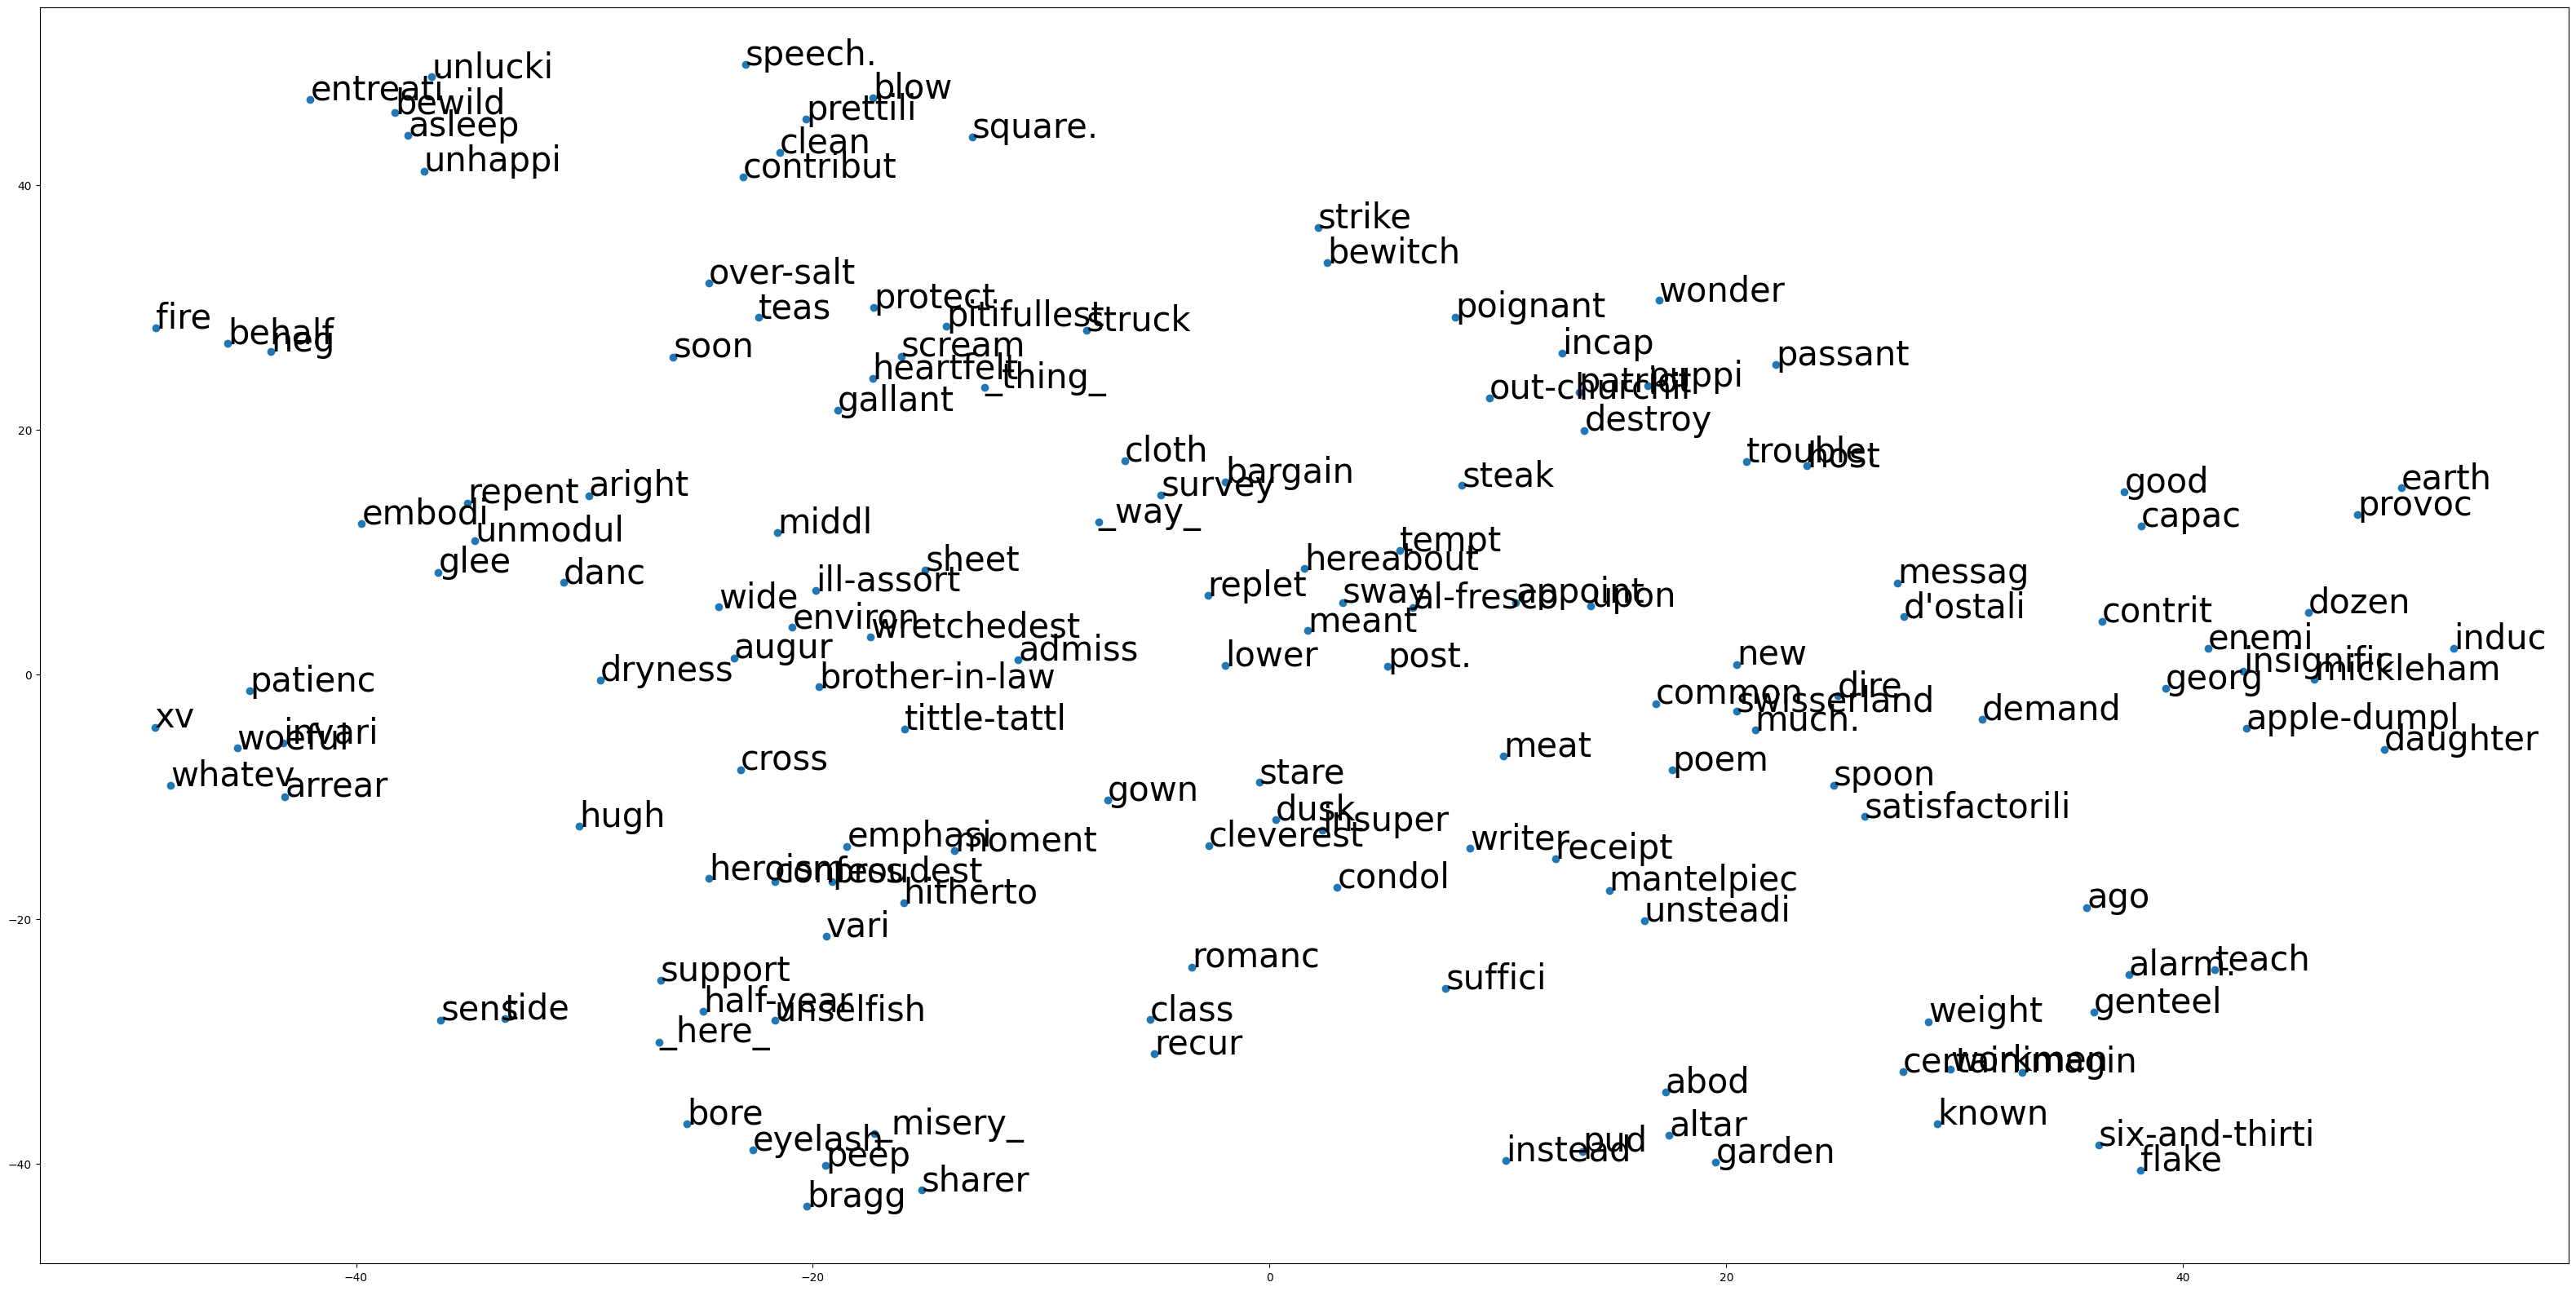

In [68]:
render_TSNE(i2w, skipgram.embedding.weight.cpu().detach().numpy())